In [1]:
#Analyze e-commerce user behavior to enhance product recommendation and sales strategies
#personalized product recommendations and optimize sales strayegies.

In [1]:
import numpy as np 
import pandas as pd 
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import squarify
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## **Dataset**


Ecommerce behaviour data from multi category store.

Dataset contains events of 285 million users from ecommerce website.

For purpose of analysis 2019 dataset is used.



In [3]:
df = pd.read_csv(r"C:\Users\ranu1\Downloads\E-comercedataset\2019-Nov.csv")

In [4]:
df.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c
6,2019-11-01 00:00:01 UTC,view,1306421,2053013558920217191,computers.notebook,hp,514.56,514028527,df8184cc-3694-4549-8c8c-6b5171877376
7,2019-11-01 00:00:02 UTC,view,15900065,2053013558190408249,NaN,rondell,30.86,518574284,5e6ef132-4d7c-4730-8c7f-85aa4082588f
8,2019-11-01 00:00:02 UTC,view,12708937,2053013553559896355,NaN,michelin,72.72,532364121,0a899268-31eb-46de-898d-09b2da950b24
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0


In [5]:
df.count()

event_time       67501979
event_type       67501979
product_id       67501979
category_id      67501979
category_code    45603808
brand            58277901
price            67501979
user_id          67501979
user_session     67501969
dtype: int64

In [6]:
df=reduce_mem_usage(df)

Memory usage after optimization is: 3733.74 MB
Decreased by 19.4%


In [7]:
df.shape

(67501979, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int32  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float16
 7   user_id        int32  
 8   user_session   object 
dtypes: float16(1), int32(2), int64(1), object(5)
memory usage: 3.6+ GB


# Rows

Each row in dataset describes an event.

There were around 6 crore 75 lakh rows present in initial dataset.

# Columns

There were 9 columns


In [9]:
df.describe().T

C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


,count,mean,std,min,25%,50%,75%,max
product_id,67501979.0,1.251406e+07,1.725741e+07,1.000365e+06,1.305977e+06,5.100568e+06,1.730075e+07,1.000286e+08
category_id,67501979.0,2.057898e+18,2.012549e+16,2.053014e+18,2.053014e+18,2.053014e+18,2.053014e+18,2.187708e+18
price,67501979.0,NaN,NaN,0.000000e+00,6.925000e+01,1.657500e+02,3.602500e+02,2.574000e+03
user_id,67501979.0,5.386397e+08,2.288516e+07,1.030022e+07,5.164762e+08,5.350573e+08,5.610794e+08,5.799699e+08


In [10]:
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

In [11]:
#no of rows with null values
print("category_code ",df['category_code'].isnull().sum())
print("brand ",df['brand'].isnull().sum())
print("Both ",(df['category_code'].isnull() & df['brand'].isnull()).sum())

category_code  21898171
brand  9224078
Both  5709840


In [12]:
df = df.dropna()



*   21 Lakh with missing category code
*   92 Lakhs with missing branch
*   Total  57 lakh with null values in category 
    code or branch or both

Since we have ample data we drop the data with null values and data is now reduced to 4 crores


In [13]:
df.shape

(42089564, 9)

In [14]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [15]:
num_users = df['user_id'].nunique()
num_products = df['product_id'].nunique()
num_categories = df['category_id'].nunique()
num_taxonomies = df['category_code'].nunique()
num_brands = df['brand'].nunique()
print('Total number of users: ',num_users)
print('Total number of products: ', num_products)
print('Total number of categories: ', num_categories)
print('Total number of taxonomies: ', num_taxonomies)
print('Total number of brands: ', num_brands)

Total number of users:  2862935
Total number of products:  69773
Total number of categories:  270
Total number of taxonomies:  129
Total number of brands:  1987


# No of visitors by date

To analyze the number of visitors by date we have grouped the dataset by columns event_time and user_id.

The no.of visitors on each date is extracted and shown in the graph below.


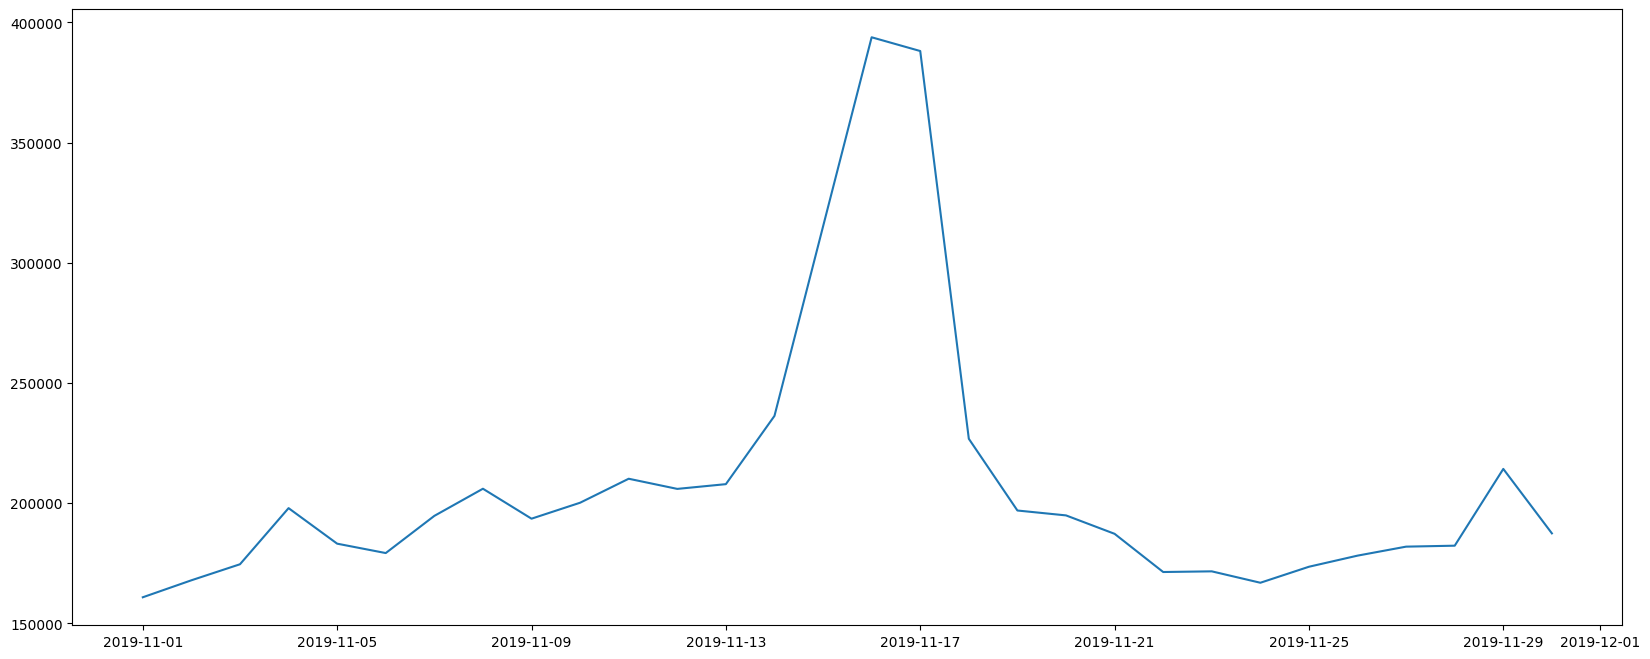

In [16]:

#number of vistors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()



*  There is a peak in the curve on 17th Nov 2019(Sunday).Based on the traffic we can infer that people are mostly free on sunday to shop.
*  Another peak could be found on  29th Nov 2019 which was Black Friday where the ecommerce websites displays the sneakpeak of all offers during the sale.



# Most bought brand

            event_time  event_type  product_id  category_id  category_code  \
brand                                                                        
a-elita            320         320         320          320            320   
aardwolf           478         478         478          478            478   
abtoys              91          91          91           91             91   
accumaster          19          19          19           19             19   
acd                 50          50          50           50             50   
...                ...         ...         ...          ...            ...   
zpao                 6           6           6            6              6   
zte               9969        9969        9969         9969           9969   
zubr             10658       10658       10658        10658          10658   
zuru                 4           4           4            4              4   
zwerg               18          18          18           18     

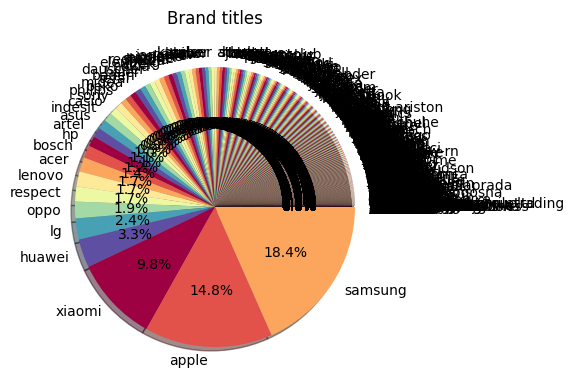

In [17]:
# most bought brand
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()





 The above *piechart* shows the popularity of brands in the market with *"Samsung"* being the top brand




# Popular product categories

A squarify plot is used to visually represent which categories of product has drawn more demand from customer.

Most of the items are given two category codes separated by a point.First word depicts the main category of the item whereas the following word depicts its sub category.

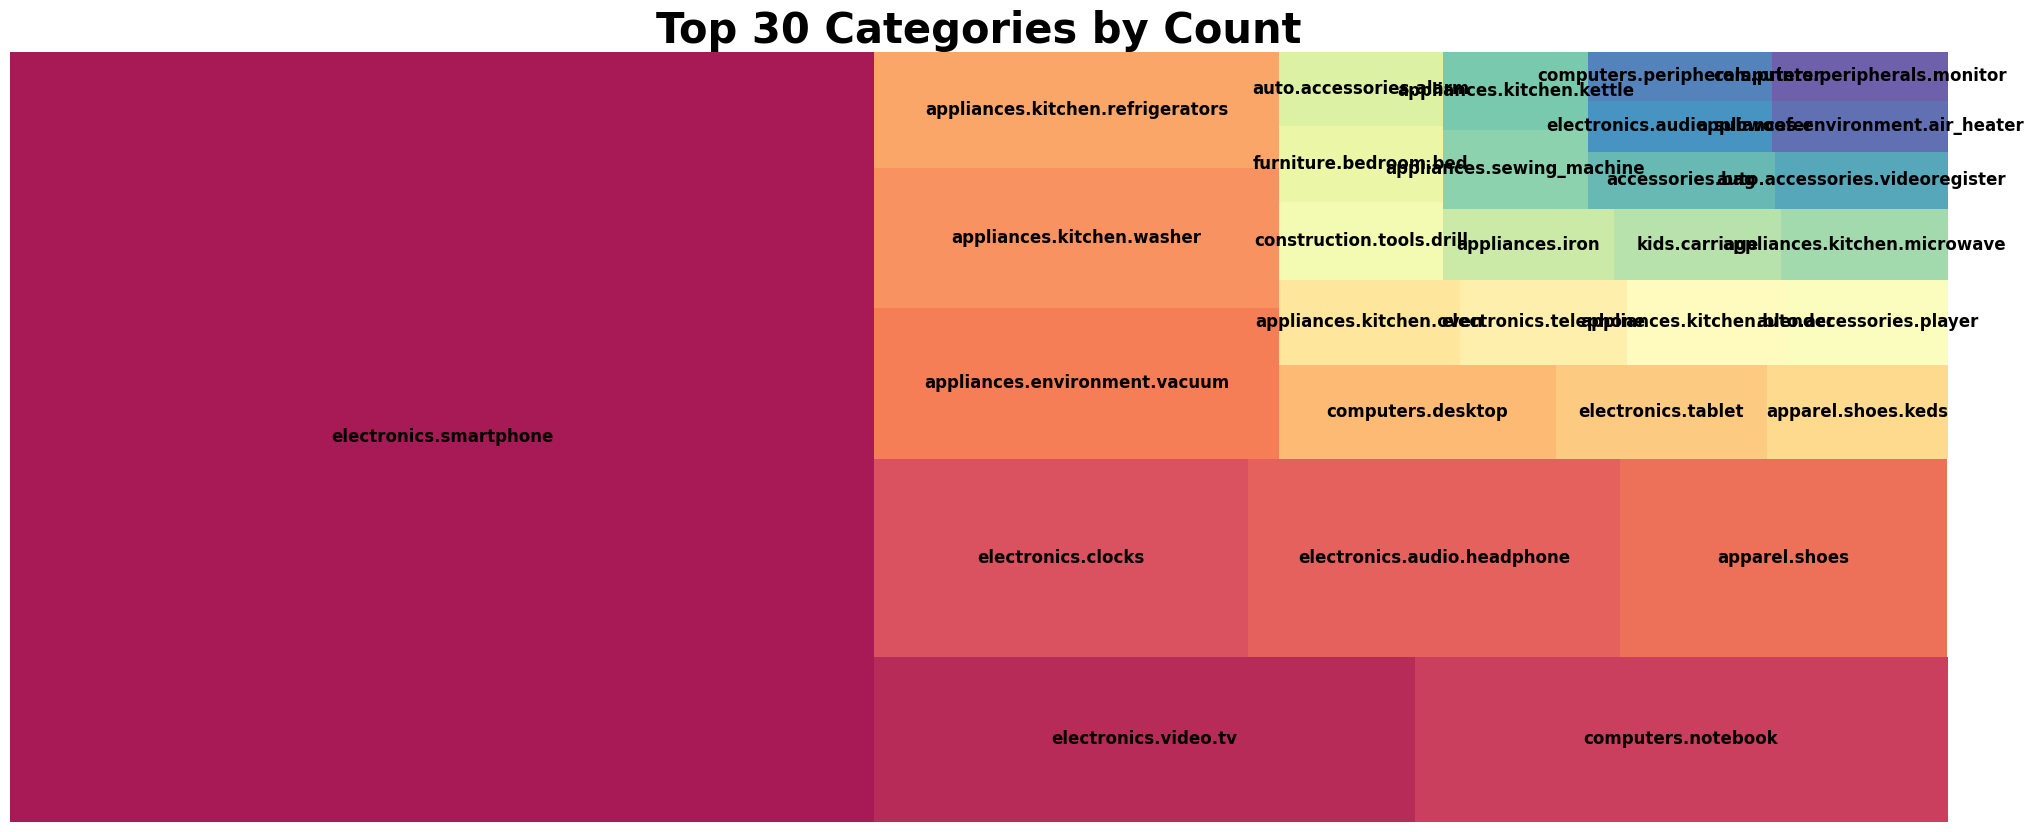

In [18]:
# popular product categories
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors

# Parameters
top_category_n = 30

# Get top categories and their counts
top_category = df['category_code'].value_counts()[:top_category_n].sort_values(ascending=False)

# Setting up the color map
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, top_category_n)]

# Plotting the treemap
plt.figure(figsize=(25, 10))
squarify.plot(
    sizes=top_category, 
    label=top_category.index.array, 
    color=colors, 
    alpha=0.9, 
    text_kwargs={'fontsize': 12, 'weight':'bold' , 'color': 'black'}
)

# Turn off the axes
plt.axis('off')

# Adding a title
plt.title('Top 30 Categories by Count', fontsize=30, weight='bold')

# Display the plot
plt.show()

#"Smartphones" which comes under electronics goods are more popular.

#A huge fraction of items bought are electronics which concludes there#
#have been major discounts and price deals available on ecommerce platform.

"Smartphones" which comes under electronics goods are more popular.

A huge fraction of items bought are electronics which concludes there have been major discounts and price deals available on ecommerce platform.

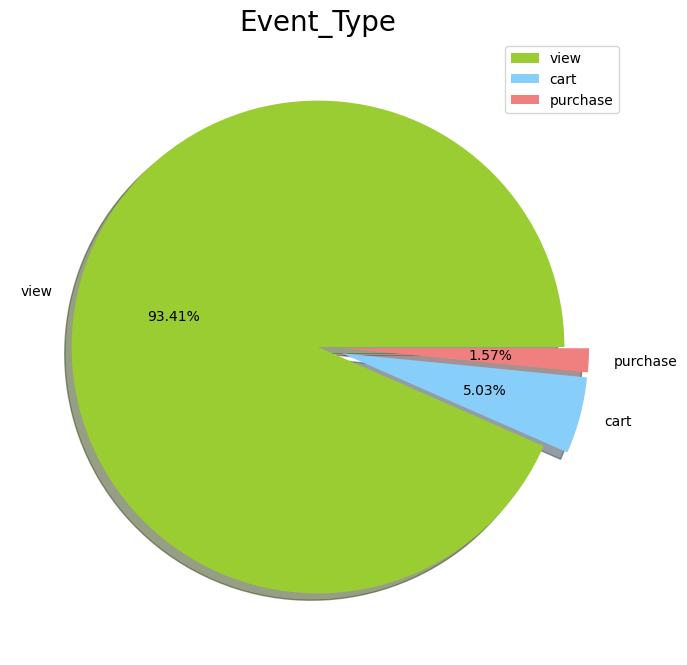

In [19]:
#event_type

labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Summary of What These Percentages Tell You:

High Drop-Off: There is a significant drop-off from viewing to adding items to the cart and from adding items to the cart to making a purchase.

Conversion Funnel Health: Highlights the effectiveness of the sales funnel and potential issues in converting interest into sales.

Customer Journey: Provides insights into where users are losing interest or encountering barriers in the purchasing process.

# prices and brands

Text(0.5, 1.0, 'Distribution of price')

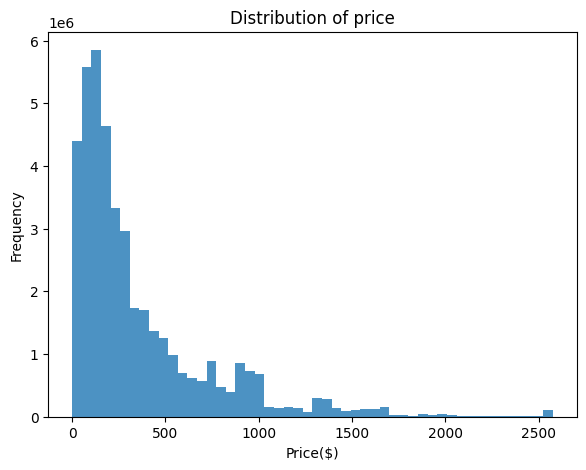

In [20]:
#prices and brands
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1) 
plt.hist(df['price'], bins=50, alpha=0.8)
plt.xlabel('Price($)')
plt.ylabel('Frequency')
plt.title('Distribution of price')



Common Price Range: The tallest bar(s) indicate the most frequent price range, which might suggest a common price point in the dataset.

Price Distribution: Understanding the price distribution can help in pricing strategies, identifying market segments, or analyzing affordability. For example, a right-skewed distribution might suggest a market with a majority of low-priced items and a few high-priced luxury items.

# Brandwise sales of all event types

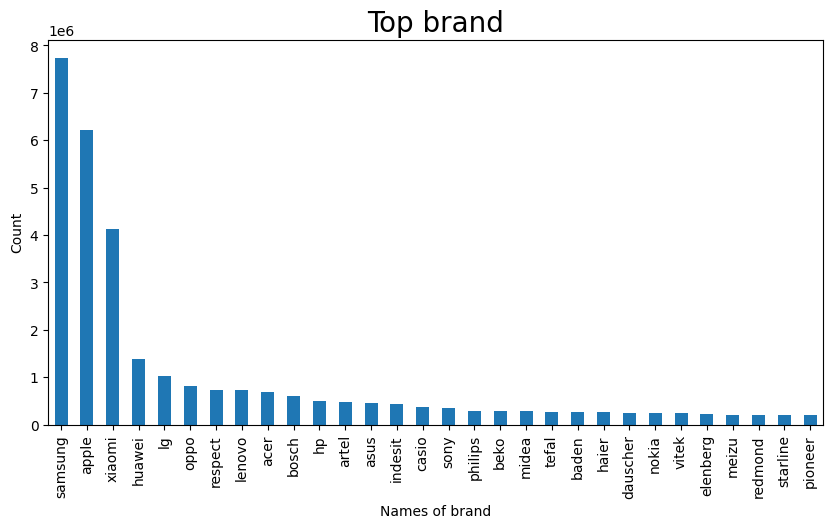

In [21]:
#Brandwise sales of all event types
df['brand'].value_counts().head(30).plot.bar(figsize = (10,5))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

#Samsung is the top brand

From the above plot we infer "Samsung" is the top brand where we consider all type of events(view,cart and purchase)


We consider only purchase events  which tells us which brand is the first player in the market

brand
samsung     198669
apple       165681
xiaomi       57908
huawei       23466
oppo         15080
             ...  
wenyi            1
scooter          1
libero           1
easycamp         1
toro             1
Name: count, Length: 1236, dtype: int64


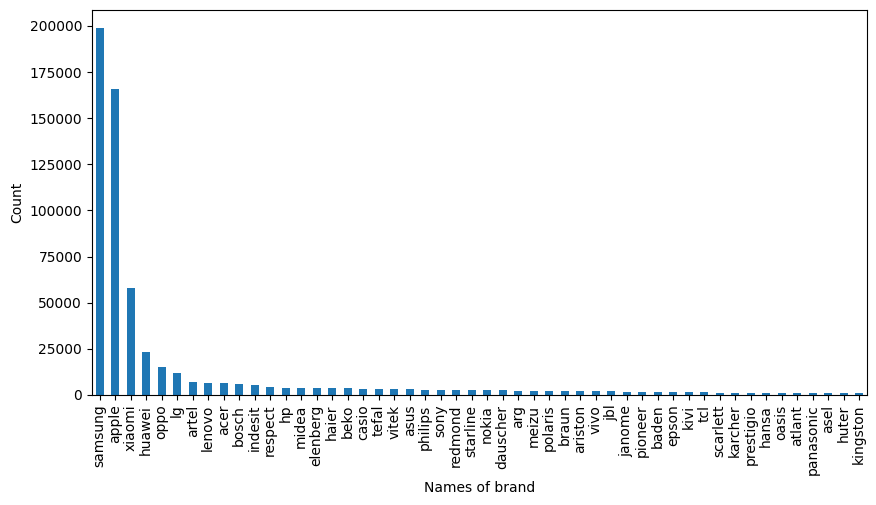

In [22]:
d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(50).plot.bar(figsize =(10,5))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()


*   As seen in the graph samsung is again the top in the market closely followed by apple.

*   A number of brands with only one product sale each including cameo,Imetec and Zapco take the last position.





In [23]:
top_player = df['brand'].value_counts()[0]
second_player = df['brand'].value_counts()[1]
last_player = df['brand'].value_counts()[-1]
print("Top brand saw " +str((top_player/second_player)*100)+"%more sales than second_player in the market")
print("Top brand saw " +str((top_player/last_player)*100)+"%more sales than bottom player in the market")

C:\Users\ranu1\AppData\Local\Temp\ipykernel_18216\934681152.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_player = df['brand'].value_counts()[0]
C:\Users\ranu1\AppData\Local\Temp\ipykernel_18216\934681152.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_player = df['brand'].value_counts()[1]


Top brand saw 124.45206713979948%more sales than second_player in the market
Top brand saw 773332700.0%more sales than bottom player in the market


C:\Users\ranu1\AppData\Local\Temp\ipykernel_18216\934681152.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_player = df['brand'].value_counts()[-1]


# Purchase path
The standard idea is that most people first view an item,compare with other item and add to cart to buy specific item.not many people follow this path.

Given below is an example of customer who followed the path view->cart->purchase

In [24]:
#purchase path
df.loc[df.user_session =="ef3daa59-4936-43e5-a530-32902f64b2f4"].sort_values(by = "event_time")

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2169,2019-11-01 00:14:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2275,2019-11-01 00:15:10 UTC,cart,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2309,2019-11-01 00:15:23 UTC,purchase,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2374,2019-11-01 00:15:46 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4


# User's journey

The code below shows the user who purchased a apple product after which he views other products manufactured by the same company "apple".

In [25]:
#user's journey
user_ID = 518267348
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1748,2019-11-01 00:11:48 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1822,2019-11-01 00:12:16 UTC,cart,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1951,2019-11-01 00:13:10 UTC,purchase,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
2285,2019-11-01 00:15:14 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,af95bb12-1956-40a4-a703-fcae492b2fb6
2520,2019-11-01 00:16:46 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2678,2019-11-01 00:17:47 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2706,2019-11-01 00:17:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2800,2019-11-01 00:18:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2868,2019-11-01 00:18:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2875,2019-11-01 00:19:00 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464


The user below views an android phone ,purchases the same and goes on to view other apple products clock and phone. He buys the apple clock.

The inference is apple customers wear brand loyalty.Apple customers have only viewed other products of apple whereas android customers view other company products also.


In [26]:
user_ID = 513351129
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
49,2019-11-01 00:00:17 UTC,view,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
168,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
281,2019-11-01 00:01:57 UTC,view,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,d3ff456e-0537-4c72-b126-752dd3e135db
57932963,2019-11-25 09:44:42 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57933375,2019-11-25 09:44:57 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57933966,2019-11-25 09:45:21 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57934030,2019-11-25 09:45:23 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57935200,2019-11-25 09:46:11 UTC,purchase,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
60185950,2019-11-26 16:05:24 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,543b61ca-c953-469d-95c9-71aeb2480749
60188988,2019-11-26 16:06:54 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,543b61ca-c953-469d-95c9-71aeb2480749


# Preparing data

To predict whether the product added to the cart is actually purchased by the customer based on factors such as its category,event_weekday,activity of the user in that session etc

We added some new features in training data


*   category_code_level1 - category
*   category_code_level2 - subcategory
*   event_weekday - weekday of the event
*   activity_count - no.of activity in that session

*   is_purchased - whether the put in cart item is purchased.


The training dataset contains every non-duplicated cart transactions with above mentioned features.We will use these features with original price and brand to predict whether the customer will eventuall purchase the item in the cart.









In [27]:
#preparing data
#List of people who has bought or added products to the cart
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
print(cart_purchase_users)

                       event_time event_type  product_id          category_id  \
40        2019-11-01 00:00:14 UTC       cart     1005014  2053013555631882655   
168       2019-11-01 00:01:04 UTC   purchase     1005161  2053013555631882655   
502       2019-11-01 00:03:24 UTC       cart     1801881  2053013554415534427   
537       2019-11-01 00:03:39 UTC       cart     1005115  2053013555631882655   
707       2019-11-01 00:04:51 UTC   purchase     1004856  2053013555631882655   
...                           ...        ...         ...                  ...   
67501311  2019-11-30 23:55:04 UTC       cart     1005130  2053013555631882655   
67501367  2019-11-30 23:55:28 UTC       cart     1005105  2053013555631882655   
67501558  2019-11-30 23:56:57 UTC       cart     1005212  2053013555631882655   
67501563  2019-11-30 23:57:01 UTC       cart     3701005  2053013565983425517   
67501666  2019-11-30 23:57:45 UTC       cart    28715769  2116907519078040377   

                          c

#All activities of above users including view event

In [28]:
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]
print(cart_purchase_users_all_activity)  

                       event_time event_type  product_id          category_id  \
3         2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
9         2019-11-01 00:00:02 UTC       view     1004258  2053013555631882655   
14        2019-11-01 00:00:05 UTC       view     4600658  2053013563944993659   
28        2019-11-01 00:00:10 UTC       view     1307350  2053013558920217191   
39        2019-11-01 00:00:14 UTC       view     1002544  2053013555631882655   
...                           ...        ...         ...                  ...   
67501953  2019-11-30 23:59:49 UTC       view     1801141  2053013554415534427   
67501965  2019-11-30 23:59:53 UTC       view     4804294  2053013554658804075   
67501975  2019-11-30 23:59:58 UTC       view    28719425  2053013565639492569   
67501976  2019-11-30 23:59:59 UTC       view     1004833  2053013555631882655   
67501977  2019-11-30 23:59:59 UTC       view     2701706  2053013563911439225   

                           

# Counting no of activities in one session

In [29]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

                                 user_session  activity_count
0        00001a36-7f5a-4c05-a52b-e9935de5331e               1
1        0000264c-75d2-4049-ab5d-93e6dd64650d               1
2        00002e0a-8b74-4c72-bb5a-99e04fa264da               4
3        00002ea0-6a36-47a9-acc9-5b0024c586f9               8
4        0000334c-e481-4c49-b66b-53e3d2e2d2d0               1
...                                       ...             ...
4285186  ffffee6f-ecc0-43c7-b0cd-13f4ce8d8172               2
4285187  fffff7d0-c21e-4a82-83f1-67685ce6ed1c               3
4285188  fffff826-edc8-4d19-9dd7-936ef133bc89               1
4285189  fffffbbe-9f76-403b-b17c-e7c68c48ea1c               4
4285190  fffffd01-5f95-4916-b2dd-491c603d6c9c               6

[4285191 rows x 2 columns]


Extract event date from event_time column and find on which date the activity occurs

In [30]:
def convert_time_to_date(utc_timestamp):
  utc_date = datetime.strptime(utc_timestamp[0:10],'%Y-%m-%d').date()
  return utc_date

In [31]:
df['event_date'] = df['event_time'].apply(lambda s:convert_time_to_date(s))

In [32]:
#Time Series Analysis

parse_date = ['date']
parse_time = ['time']
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.00,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.75,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.00,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.25,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.00,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,2019-11-01


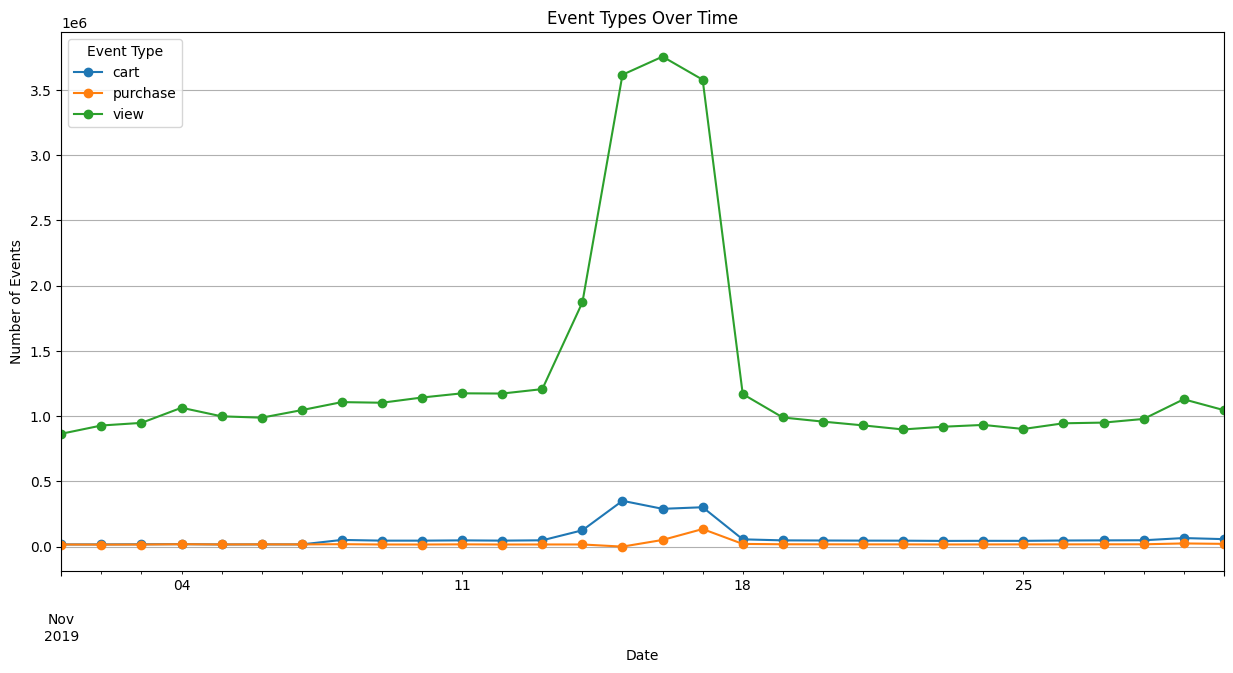

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already loaded
# Convert 'event_date' to datetime if it's not already
df['event_date'] = pd.to_datetime(df['event_date'])

# Create a DataFrame with 'event_date' and 'event_type'
timeseries_df = df[['event_date', 'event_type']]

# Aggregate data: count event types per day
event_counts = timeseries_df.groupby(['event_date', 'event_type']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(15, 7))
event_counts.plot(ax=plt.gca(), marker='o')

plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Event Types Over Time')
plt.legend(title='Event Type', loc='upper left')
plt.grid(True)

plt.show()



Splitting of category and sub category is done by string handling

In [34]:
#splitting of category and sub category is done by string handling
import pandas as pd
import numpy as np
# Filter and drop duplicates
df_targets = df.loc[df["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=['event_type', 'product_id', 'price', 'user_id', 'user_session'])

# Create and update 'is_purchased'
df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])["is_purchased"].transform("max")

# Filter to keep only 'cart' events and drop duplicates
df_targets = df_targets.loc[df_targets["event_type"] == 'cart'].drop_duplicates(["user_session", "product_id", "is_purchased"])

# Extract weekday
df_targets['event_weekday'] = df_targets['event_date'].apply(lambda s: s.weekday())

# Drop rows with any missing values
df_targets.dropna(how='any', inplace=True)

# Split 'category_code' and handle cases with missing parts
split_codes = df_targets["category_code"].str.split(".", expand=True)
df_targets["category_code_level1"] = split_codes[0].astype('category')

# Use .get() to avoid KeyError if the second part doesn't exist
df_targets["category_code_level2"] = split_codes[1] if 1 in split_codes.columns else pd.NA
df_targets["category_code_level2"] = df_targets["category_code_level2"].astype('category')

print(df_targets)

                       event_time event_type  product_id          category_id  \
40        2019-11-01 00:00:14 UTC       cart     1005014  2053013555631882655   
502       2019-11-01 00:03:24 UTC       cart     1801881  2053013554415534427   
537       2019-11-01 00:03:39 UTC       cart     1005115  2053013555631882655   
849       2019-11-01 00:05:54 UTC       cart     1002542  2053013555631882655   
956       2019-11-01 00:06:38 UTC       cart     1004856  2053013555631882655   
...                           ...        ...         ...                  ...   
67501608  2019-11-30 23:57:21 UTC       cart     1004767  2053013555631882655   
67501666  2019-11-30 23:57:45 UTC       cart    28715769  2116907519078040377   
67501756  2019-11-30 23:58:28 UTC       cart     1005132  2053013555631882655   
67501778  2019-11-30 23:58:39 UTC       cart     1005003  2053013555631882655   
67501812  2019-11-30 23:58:55 UTC       cart     3701309  2053013565983425517   

                          c

In [35]:
df_targets = df_targets.merge(activity_in_session,on = 'user_session',how ='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.000,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,2019-11-01,0,4,electronics,smartphone,1
1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.750,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,1,4,electronics,video,25
2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.500,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,2019-11-01,0,4,electronics,smartphone,2
3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.750,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,2019-11-01,0,4,electronics,smartphone,14
4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.375,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,2019-11-01,1,4,electronics,smartphone,9


In [36]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408569 entries, 0 to 1408568
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   event_time            1408569 non-null  object        
 1   event_type            1408569 non-null  object        
 2   product_id            1408569 non-null  int32         
 3   category_id           1408569 non-null  int64         
 4   category_code         1408569 non-null  object        
 5   brand                 1408569 non-null  object        
 6   price                 1408569 non-null  float16       
 7   user_id               1408569 non-null  int32         
 8   user_session          1408569 non-null  object        
 9   event_date            1408569 non-null  datetime64[ns]
 10  is_purchased          1408569 non-null  int32         
 11  event_weekday         1408569 non-null  int64         
 12  category_code_level1  1408569 non-null  ca

In [37]:
#Saving a copy of preprocessed data
df_targets.to_csv('training_data.csv')

In [38]:
df_targets = pd.read_csv('training_data.csv')

In [39]:
df_targets.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.0,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,2019-11-01,0,4,electronics,smartphone,1
1,1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.8,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,1,4,electronics,video,25
2,2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.5,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,2019-11-01,0,4,electronics,smartphone,2
3,3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.8,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,2019-11-01,0,4,electronics,smartphone,14
4,4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.4,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,2019-11-01,1,4,electronics,smartphone,9


In [45]:
df_targets 

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.0,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,2019-11-01,0,4,electronics,smartphone,1
1,1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.8,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,1,4,electronics,video,25
2,2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.5,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,2019-11-01,0,4,electronics,smartphone,2
3,3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.8,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,2019-11-01,0,4,electronics,smartphone,14
4,4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.4,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,2019-11-01,1,4,electronics,smartphone,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408564,1408564,2019-11-30 23:57:21 UTC,cart,1004767,2053013555631882655,electronics.smartphone,samsung,235.6,574868869,878a1538-ebe3-4d7f-b773-1b057b1971eb,2019-11-30,1,5,electronics,smartphone,7
1408565,1408565,2019-11-30 23:57:45 UTC,cart,28715769,2116907519078040377,apparel.shoes,nexpero,68.2,574692255,d7775cb0-2a30-4665-8ce0-a6028cad97b5,2019-11-30,0,5,apparel,shoes,7
1408566,1408566,2019-11-30 23:58:28 UTC,cart,1005132,2053013555631882655,electronics.smartphone,apple,1287.0,566460317,ad056b61-8691-aa65-0fb7-526fc67294f9,2019-11-30,0,5,electronics,smartphone,12
1408567,1408567,2019-11-30 23:58:39 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,227.6,555295228,faff950a-a998-4872-8801-693f74c5e55f,2019-11-30,0,5,electronics,smartphone,4


In [48]:
from sklearn.preprocessing import LabelEncoder

# Create a dictionary to store the mapping of original categories to encoded values
label_encodings = {}

# Function to fit and return the encoding map without transforming the data
def preview_encoding(column):
    le = LabelEncoder()
    le.fit(column)
    label_encodings[column.name] = dict(zip(le.classes_, le.transform(le.classes_)))
    return label_encodings[column.name]

# List of categorical columns to encode
categorical_columns = ['brand','category_code_level1','category_code_level2']  # replace with your actual column names

# Preview the encodings for each categorical column
for column in categorical_columns:
    encoding_map = preview_encoding(df_targets[column])
    print(f"Encoding for '{column}':")
    for original, encoded in encoding_map.items():
        print(f"  {original}: {encoded}")
    print("\n")


Encoding for 'brand':
  a-elita: 0
  aardwolf: 1
  abtoys: 2
  acd: 3
  acer: 4
  aces: 5
  acme: 6
  acqua: 7
  acron: 8
  acv: 9
  adagio: 10
  adam: 11
  adamas: 12
  adamex: 13
  adata: 14
  adidas: 15
  admira: 16
  adriatica: 17
  aeg: 18
  aero: 19
  aerocool: 20
  afox: 21
  ag: 22
  agatharuizdelaprada: 23
  agu: 24
  aiken: 25
  aimile: 26
  aimoto: 27
  air-cool: 28
  airline: 29
  aist: 30
  akai: 31
  akel: 32
  akg: 33
  akpo: 34
  akro: 35
  aksion: 36
  akvafor: 37
  akvaton: 38
  al-ko: 39
  alaskaoriginale: 40
  alca: 41
  alctron: 42
  alesis: 43
  alilo: 44
  alis: 45
  alligator: 46
  almacom: 47
  alphard: 48
  alpicool: 49
  alpina: 50
  alpine: 51
  alser: 52
  altacto: 53
  altair: 54
  alteco: 55
  alterna: 56
  alvitek: 57
  am.pm: 58
  amazon: 59
  amd: 60
  amen: 61
  amistar: 62
  ams: 63
  andromeda: 64
  anex: 65
  annaanna: 66
  annovireverberi: 67
  anon: 68
  anreks: 69
  ansmann: 70
  anta: 71
  antika: 72
  anytek: 73
  aoc: 74
  aoki: 75
  aorus: 7

#Resampling data to have equal no of purchased and not purchased items

no.of rows when the item was purchased was around 5 lakh and not purchased was around 8 lakh.

To balance data resampling is done

In [40]:
# to balance data resampling is done
is_purchase_set = df_targets[df_targets['is_purchased'] == 1]
is_purchase_set.shape[0]

522866

In [41]:
not_purchase_set = df_targets[df_targets['is_purchased'] == 0]
not_purchase_set.shape[0]

885703

In [42]:
n_samples = 500000
is_purchase_downsampled = resample(is_purchase_set,replace = False,n_samples = n_samples,random_state = 27)
not_purchase_set_downsampled = resample(not_purchase_set,replace = False,n_samples = n_samples,random_state = 27)

In [43]:
downsampled = pd.concat([is_purchase_downsampled,not_purchase_set_downsampled])
downsampled['is_purchased'].value_counts()

is_purchased
1    500000
0    500000
Name: count, dtype: int64

# Covariance matrix

In [44]:

matrix = downsampled[['brand','price','event_weekday','category_code_level1','category_code_level2','activity_count','is_purchased']]
matrix.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
matrix.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
matrix.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
matrix.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())
matrix.head()

,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count,is_purchased
235095,1042,95.25,1,1,35,9,1
1104998,4,1002.50,3,4,29,5,1
1268236,1088,168.80,2,7,40,20,1
103485,75,500.80,4,7,40,8,1
798825,1088,244.00,6,7,40,8,1


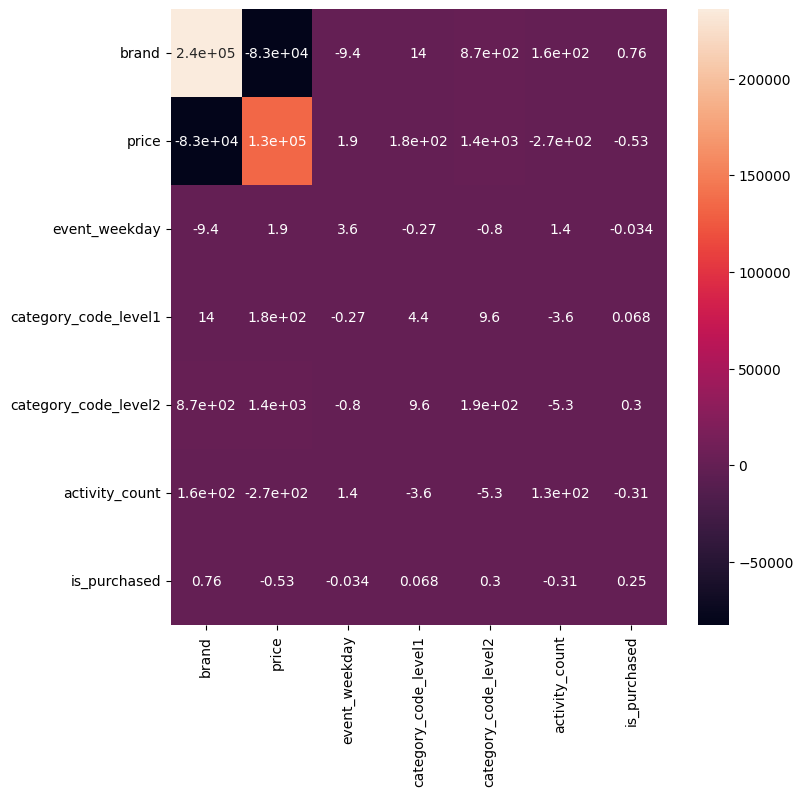

In [46]:
cov_matrix = matrix.cov()
sns.heatmap(cov_matrix,annot = True)
plt.show()

In [47]:
features = downsampled[['brand','price','event_weekday','category_code_level1','category_code_level2','activity_count']]

In [48]:
#encoding categorical attributes
features.loc[:,'brand'] =LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())
is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()


,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count
235095,1042,95.25,1,1,35,9
1104998,4,1002.50,3,4,29,5
1268236,1088,168.80,2,7,40,20
103485,75,500.80,4,7,40,8
798825,1088,244.00,6,7,40,8


In [49]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 235095 to 868963
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   brand                 1000000 non-null  object 
 1   price                 1000000 non-null  float64
 2   event_weekday         1000000 non-null  int64  
 3   category_code_level1  1000000 non-null  object 
 4   category_code_level2  1000000 non-null  object 
 5   activity_count        1000000 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 53.4+ MB


In [50]:
#Hypothesis testing - atrribute dependence
# Null Hypothesis - significant association between weekday of an event and price.

In [51]:
import pandas as pd
from scipy.stats import chi2_contingency

In [52]:
print()
print("Chi square test")
#Event weekday and price
table = pd.crosstab(features['event_weekday'],features['price'],margins = False)
stat,p,dof,expected = chi2_contingency(table)
alpha = 0.05
print("For weekday of the event and price")
print("p value is " +str(p))
if p >= alpha:
  print("No significant association between these attributes -H0 holds true")
else:
  print("significant association between these attributes -H0 is rejected")

#chi square test-association between two attributes
#weekday vs price
#user_id vs category_id


Chi square test
For weekday of the event and price
p value is 0.0
significant association between these attributes -H0 is rejected


#Chi square test - association between two attributes

Weekday vs price

user_id vs category_id

In [53]:
d1 =df[:100000]
table1 = pd.crosstab(d1['category_id'],d1['user_id'],margins = False)
stat,p,dof,expected = chi2_contingency(table1)
alpha = 0.05
print("For category code and user")
print("p value is " +str(p))
if p >= alpha:
  print("No significant association between these attributes -H0 holds true")
else:
  print("significant association between these attributes -H0 is rejected")

For category code and user
p value is 0.0
significant association between these attributes -H0 is rejected


In [63]:
d1

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.00000,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.75000,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.00000,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.25000,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.00000,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,2019-11-01
...,...,...,...,...,...,...,...,...,...,...
166312,2019-11-01 04:58:05 UTC,view,1307310,2053013558920217191,computers.notebook,acer,283.00000,522751744,2e1bc2ca-f3d1-4eb3-9cf5-706d25f2fc63,2019-11-01
166314,2019-11-01 04:58:06 UTC,view,1005074,2053013555631882655,electronics.smartphone,samsung,1143.00000,555120190,20cd7f37-e375-4d18-a49f-451910db6f71,2019-11-01
166315,2019-11-01 04:58:06 UTC,view,1004836,2053013555631882655,electronics.smartphone,samsung,229.87500,527535556,50102482-0e48-48e9-9839-0e5955cb55c0,2019-11-01
166317,2019-11-01 04:58:06 UTC,view,1004958,2053013555631882655,electronics.smartphone,xiaomi,330.75000,529333842,30b105e9-22db-4296-ab30-3b5c0be1b4d8,2019-11-01


# ML models

In [54]:

#Train Test split
X_train ,X_test ,y_train,y_test = train_test_split(features,is_purchased,test_size = 0.25,random_state =0)

In [67]:
X_train


,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count
114377,490,1080.00,4,7,10,3
675177,1088,566.00,5,7,55,6
420638,1088,1170.00,4,7,40,20
6365,1088,123.50,4,2,26,3
1129725,1090,69.56,4,8,3,4
...,...,...,...,...,...,...
1103694,1088,643.00,3,7,40,9
876491,75,958.50,6,7,40,4
1307907,1030,58.94,3,2,26,18
178350,75,746.00,6,7,40,4


In [68]:
y_train

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [55]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model = log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)

C:\Users\ranu1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.535456
Precision 0.5300845690533326
Recall 0.6206007827945285
fbeta 0.5337877712941715


In [57]:
#Decision tree classification
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)


In [58]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.672848
Precision 0.6633775832430918
Recall 0.7011613853382105
fbeta 0.672954968246052


In [65]:
import pickle

In [66]:
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)


In [59]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier()

# Fit the model on the training data
rf_model = rf_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf_model.predict(X_test)

In [60]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.686696
Precision 0.6679010122113757
Recall 0.7420379871455214
fbeta 0.6871999491503201


In [61]:
from xgboost import XGBClassifier

xg_model = XGBClassifier(learning_rate = 0.1)
xg_model.fit(X_train, y_train)
y_pred = xg_model.predict(X_test)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:brand: object, category_code_level1: object, category_code_level2: object

In [ ]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize the ANN model
ann_model = Sequential()

# Add input layer and first hidden layer with ReLU activation
ann_model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

# Add second hidden layer with ReLU activation
ann_model.add(Dense(units=32, activation='relu'))

# Add output layer (assuming a binary classification problem, use sigmoid activation)
ann_model.add(Dense(units=1, activation='sigmoid'))

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
ann_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict the labels for the test data
y_pred = ann_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)


In [ ]:
loss, accuracy = ann_model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

In [ ]:
from sklearn.metrics import precision_score 
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")


In [ ]:
from sklearn.metrics import recall_score, f1_score
# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")